In [1]:
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
from torchvision import transforms, utils
from torchvision.io import read_image
from torchvision.transforms import functional as TF
import torch
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm    
import json
from typing import List, Dict, Tuple

In [2]:
# Source: https://github.com/paplhjak/Facial-Age-Estimation-Benchmark/blob/main/lib/utils.py
def crop_image(img: np.ndarray,
               bbox: List[int],
               out_size: Tuple[int],
               margin: Tuple[float] = (0, 0),
               one_based_bbox: bool = True):
    """
        Crop subimage around bounding box extended by a margin.

    Input:
     img 
     bbox = [A_col,A_row,B_col,B_row,C_col,C_row,D_col,D_row] bounding box
     out_size (cols,rows) size of output image
     margin 
     one_based_bbox [bool] if True assumes bbox to be given on 1-base coordinates
    Output:
     dst: output image [numpy array]
     M: affine transformation used for the crop

    Args:
        img (np.ndarray): Input image.
        bbox (List[int]): [A_col,A_row,B_col,B_row,C_col,C_row,D_col,D_row] bounding box, see README for more information.
        out_size (Tuple[int]): (cols,rows) size of output image.
        margin (Tuple[float], optional): (horizontal, vertical) margin; portion of bonding box size by which to extend the specified bounding box. Defaults to (0, 0).
        one_based_bbox (bool, optional): If True assumes that the bbox is given on coordinates starting with 1 instead of 0. Defaults to True.

    Returns:
        _type_: _description_
    """

    A = np.float32([bbox[0], bbox[1]])
    B = np.float32([bbox[2], bbox[3]])
    C = np.float32([bbox[4], bbox[5]])
    D = np.float32([bbox[6], bbox[7]])

    if one_based_bbox:
        A = A - 1
        B = B - 1
        C = C - 1
        D = D - 1

    ext_A = A + (A-B)*margin[0] + (A-D)*margin[1]
    ext_B = B + (B-A)*margin[0] + (B-C)*margin[1]
    ext_C = C + (C-D)*margin[0] + (C-B)*margin[1]

    pts1 = np.float32([ext_A, ext_B, ext_C])
    pts2 = np.float32([[0, 0], [out_size[0]-1, 0],
                      [out_size[0]-1, out_size[1]-1]])

    M = cv.getAffineTransform(pts1, pts2)
    dst = cv.warpAffine(img, M, (out_size[0], out_size[1]))

    return dst, M

# FGNET

/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/Datasets/FGNET/FGNET/images/002A05.JPG
[-39, 11, 450, 6, 454, 495, -34, 500]
Age: 5
folder: 2


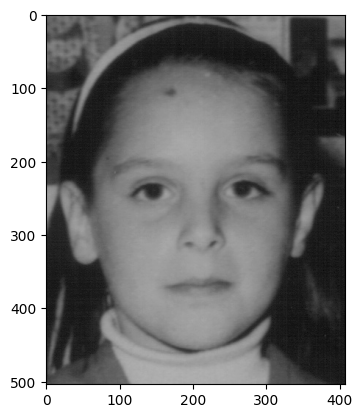

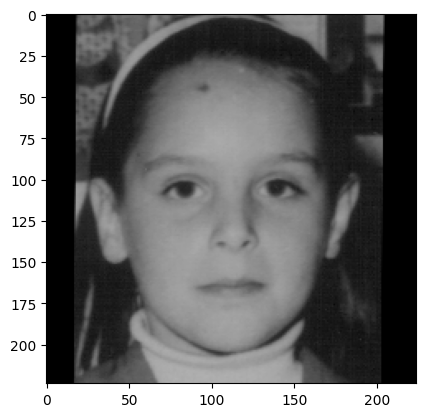

In [3]:
data_path = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/Datasets/FGNET/FGNET/images/"
j_file = open("/mnt/d/chinghsien/Documents/NTU/Master_Thesis/AGMixer/annotations/FG-Net_aligned.json", "r")
json_fgnet = json.load(j_file)

pool = [0, 1, 2, 3, 4, 5]

age_list = []
for idx, i in enumerate(json_fgnet):
    age_list.append(i['age'])
    if idx < 122:
        continue
    folder = i["folder"]
    # if folder in pool:
    #     print("In Folder")
    age = i['age']
    # gender = i['gender']
    img_path = data_path + i['img_path'].split('/', 2)[2]
    print(img_path)
    img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
    aligned_bbox = i['aligned_bbox']
    print(aligned_bbox)
    pts = np.array([[aligned_bbox[0], aligned_bbox[1]],
                [aligned_bbox[2], aligned_bbox[3]],
                [aligned_bbox[4], aligned_bbox[5]],
                [aligned_bbox[6], aligned_bbox[7]]], dtype=np.int32)
    
    
    # out_size = (int(224*(1+0.05*2)), int(224*(1+0.05*2)))
    out_size = (int(224), int(224))
    cropped_img, M = crop_image(img, aligned_bbox, out_size)
    
    
    print(f"Age: {age}") #, Gender: {gender}")
    print(f"folder: {folder}")
    plt.imshow(img)
    plt.show()
    
    plt.imshow(cropped_img)
    plt.show()
    break
    

# Mark FGNET Gender

In [4]:
from datasets.Dataset import build_dataset
from models.Networks import build_model
from utils.order_loss import order_loss, euclidean_loss
import clip
from utils.utils import seed_torch

In [5]:
seed_torch(42)
model = build_model("rc", "utk-call")
model.to("cuda:0")
ckpt_path0 = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/SmallExp/checkpoints/utk-call/AGMixerV1/6_mae_3.68_cs_73.75_GAcc_96.91______choose/36_BS32_50ep_FE_last6_split0_TestSet_mae3.669_cs5_73.55_gAcc_96.85/31Epochs_AgeGender_MixerV1_FaRL_64epckpt_loss1.762884_TrainMae0.779_ValMae3.685_CS@5_0.7380_GAcc_0.9712.pt"
ckpt_path1 = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/SmallExp/checkpoints/utk-call/AGMixerV1/6_mae_3.68_cs_73.75_GAcc_96.91______choose/37_BS32_50ep_FE_last6_split1_TestSet_mae3.680_cs5_73.68_gAcc_97.18/50Epochs_AgeGender_MixerV1_FaRL_64epckpt_loss1.359478_TrainMae0.615_ValMae3.593_CS@5_0.7388_GAcc_0.9670.pt"
ckpt_path2 = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/SmallExp/checkpoints/utk-call/AGMixerV1/6_mae_3.68_cs_73.75_GAcc_96.91______choose/38_BS32_50ep_FE_last6_split2_TestSet_mae3.756_cs5_73.54_gAcc_96.76/47Epochs_AgeGender_MixerV1_FaRL_64epckpt_loss1.086757_TrainMae0.492_ValMae3.707_CS@5_0.7387_GAcc_0.9730.pt"
ckpt_path3 = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/SmallExp/checkpoints/utk-call/AGMixerV1/6_mae_3.68_cs_73.75_GAcc_96.91______choose/39_BS32_50ep_FE_last6_split3_TestSet_mae3.654_cs5_73.87_gAcc_96.83/49Epochs_AgeGender_MixerV1_FaRL_64epckpt_loss1.109144_TrainMae0.501_ValMae3.783_CS@5_0.7298_GAcc_0.9674.pt"
ckpt_path4 = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/SmallExp/checkpoints/utk-call/AGMixerV1/6_mae_3.68_cs_73.75_GAcc_96.91______choose/40_BS32_50ep_FE_last6_split4_TestSet_mae3.637_cs5_74.12_gAcc_96.91/44Epochs_AgeGender_MixerV1_FaRL_64epckpt_loss1.304171_TrainMae0.568_ValMae3.756_CS@5_0.7304_GAcc_0.9681.pt"
ckpt = []
ckpt.append(torch.load(ckpt_path0))
ckpt.append(torch.load(ckpt_path1))
ckpt.append(torch.load(ckpt_path2))
ckpt.append(torch.load(ckpt_path3))
ckpt.append(torch.load(ckpt_path4))
# model.load_state_dict(ckpt['model_state_dict'])


data_path = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/Datasets/FGNET/FGNET/images/"
j_file = open("/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/Datasets/A_call/Facial-Age-Estimation-Benchmark-Databases/FG-Net_aligned.json", "r")
json_fgnet = json.load(j_file)

_, preprocess = clip.load("ViT-B/16", device="cpu")

gender_list = [[] for _ in range(82)]
confidence_list = [[] for _ in range(82)]
with tqdm(total=len(json_fgnet)) as tbar:
   for idx, i in enumerate(json_fgnet):
      img_path = data_path + i['img_path'].split('/', 2)[2].split(".")[0] + "." + i['img_path'].split('/', 2)[2].split(".")[1].upper()
      # print(img_path)
      img = Image.open(img_path)
      img = np.array(img)
      folder = i['folder']
      aligned_bbox = i['aligned_bbox']

      out_size = (int(224), int(224))
      cropped_img, M = crop_image(img, aligned_bbox, out_size)
   
      img_pre = preprocess(Image.fromarray(cropped_img)).to("cuda:0")
      img_pre = img_pre.unsqueeze(dim=0)

      g_list = []
      for iter in range(0, 5):
         
         model.load_state_dict(ckpt[iter]['model_state_dict'])
         with torch.no_grad():
            age_out_1, gender_out, age_out_2, features1, features2 = model(img_pre)

         g_pred = torch.max(torch.nn.functional.softmax(gender_out, dim=1), dim=1)[1]
         g_pred = g_pred.cpu().numpy().squeeze()
         g_list.append(int(g_pred))
   
         # conf = torch.max(torch.nn.functional.softmax(gender_out, dim=1), dim=1)[0].cpu().numpy().squeeze()
         # confidence_list.append(conf)
      
      g_pred = max(set(g_list), key = g_list.count)
   
      # conf = torch.max(torch.nn.functional.softmax(gender_out, dim=1), dim=1)[0].cpu().numpy().squeeze()
      # confidence_list[folder-1].append(conf)
      if g_pred == 0 :
         gender_list[folder-1].append('M')
      elif g_pred == 1:
         gender_list[folder-1].append('F')
      tbar.update(1)



TypeError: build_model() takes from 0 to 1 positional arguments but 2 were given

In [6]:
print(gender_list[8])

['F', 'M', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']


In [7]:
print(gender_list[8].count('F'))
print(gender_list[8].count('M'))

# ['F', 'M', 'F', 'F', 'F', 'F', 'M', 'F', 'F', 'F', 'F', 'F', 'F']

12
1


In [8]:

gender_list_check = []
idx_count = []
for idx, list in enumerate(gender_list):
    Male_count = gender_list[idx].count('M')
    Female_count = gender_list[idx].count('F')
    if Male_count > Female_count:
        gender = 'M'
    elif Female_count > Male_count:
        gender = 'F'
    else:
        print("Bigender!")
    gender_list_check.append(gender)

print(gender_list_check[8])

F


In [9]:
new_json_fgnet = []

with tqdm(total=len(json_fgnet)) as tbar:
   for idx, data in enumerate(json_fgnet):
      folder = data['folder']
      gender = gender_list_check[folder-1]
      gender_pair = {"gender": gender}
      data.update(gender_pair)
      new_json_fgnet.append(data)
      tbar.update(1)
        

with open("/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/Datasets/A_call/Facial-Age-Estimation-Benchmark-Databases/FG-Net_aligned_update_gender.json", 'w') as f:
    json.dump(new_json_fgnet, f, indent=4)

  0%|          | 0/1002 [00:00<?, ?it/s]

In [10]:
for idx, g in enumerate(gender_list_check):
    print(f"{idx+1:03}A: {g}")

001A: M
002A: F
003A: F
004A: M
005A: F
006A: M
007A: M
008A: F
009A: F
010A: F
011A: M
012A: F
013A: M
014A: F
015A: F
016A: M
017A: M
018A: F
019A: M
020A: F
021A: F
022A: M
023A: M
024A: M
025A: F
026A: F
027A: F
028A: M
029A: M
030A: F
031A: M
032A: F
033A: M
034A: F
035A: M
036A: M
037A: M
038A: M
039A: F
040A: M
041A: M
042A: M
043A: F
044A: M
045A: M
046A: M
047A: F
048A: M
049A: F
050A: M
051A: M
052A: F
053A: M
054A: F
055A: M
056A: M
057A: M
058A: M
059A: F
060A: F
061A: F
062A: F
063A: M
064A: M
065A: F
066A: M
067A: F
068A: M
069A: M
070A: M
071A: M
072A: F
073A: F
074A: M
075A: M
076A: F
077A: F
078A: M
079A: M
080A: M
081A: M
082A: M


# CLAP2016

/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/Datasets/CLAP2016/train/003337.jpg
[217, 33, 402, 11, 424, 196, 239, 218]
Age: 31
folder: 0


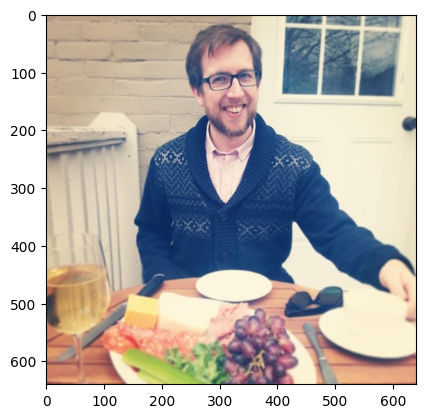

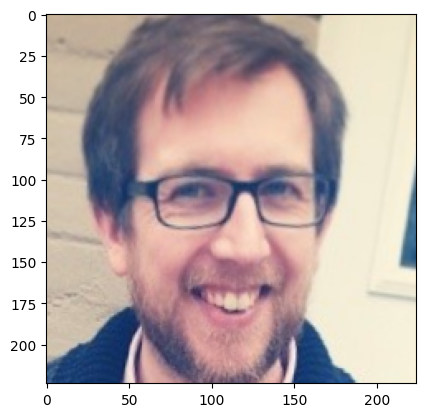

In [3]:
import torch

data_path = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/Datasets/CLAP2016/"
j_file = open("/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/Datasets/A_call/Facial-Age-Estimation-Benchmark-Databases/CLAP2016_aligned.json", "r")
json_clap = json.load(j_file)

pool = [0, 1, 2, 3, 4, 5]

age_list = []
for idx, i in enumerate(json_clap):
    age_list.append(i['age'])
    if idx < 156:
        continue
    folder = i["folder"]
    # if folder in pool:
    #     print("In Folder")
    age = i['age']
    # gender = i['gender']
    img_path = data_path + i['img_path'].split('/', 1)[1]
    print(img_path)
    img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
    aligned_bbox = i['aligned_bbox']
    print(aligned_bbox)
    pts = np.array([[aligned_bbox[0], aligned_bbox[1]],
                [aligned_bbox[2], aligned_bbox[3]],
                [aligned_bbox[4], aligned_bbox[5]],
                [aligned_bbox[6], aligned_bbox[7]]], dtype=np.int32)
    
    
    # out_size = (int(224*(1+0.05*2)), int(224*(1+0.05*2)))
    out_size = (int(224), int(224))
    cropped_img, M= crop_image(img, aligned_bbox, out_size)
    
    
    print(f"Age: {age}") #, Gender: {gender}")
    print(f"folder: {folder}")
    plt.imshow(img)
    plt.show()
    
    plt.imshow(cropped_img)
    plt.show()

    
    break

In [4]:
from datasets.Dataset_utk import build_dataset
from models.Network_AgeEst import build_model, build_Gender_model
from utils.order_loss import order_loss, euclidean_loss
import clip
from SexEff_train import seed_torch

In [5]:
seed_torch(42)
model = build_model("rc", "utk-call")
model.to("cuda:0")
ckpt_path0 = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/SmallExp/checkpoints/utk-call/AGMixerV1_ablation/All_ablation/First_round/14_no_LayerNorm_in_mlp/1_noLayerNorm_inMLP_BS32_50ep_FE_last6_split0_TestSet_mae3.640_cs5_73.84_gAcc_96.83/42Epochs_AgeGender_MixerV1_FaRL_64epckpt_loss1.536747_TrainMae0.649_ValMae3.659_CS@5_0.7409_GAcc_0.9705.pt"
ckpt_path1 = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/SmallExp/checkpoints/utk-call/AGMixerV1_ablation/All_ablation/First_round/14_no_LayerNorm_in_mlp/2_noLayerNorm_inMLP_BS32_50ep_FE_last6_split1_TestSet_mae3.682_cs5_73.89_gAcc_97.22/40Epochs_AgeGender_MixerV1_FaRL_64epckpt_loss1.642798_TrainMae0.686_ValMae3.586_CS@5_0.7444_GAcc_0.9664.pt"
ckpt_path2 = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/SmallExp/checkpoints/utk-call/AGMixerV1_ablation/All_ablation/First_round/14_no_LayerNorm_in_mlp/3_noLayerNorm_inMLP_BS32_50ep_FE_last6_split2_TestSet_mae3.752_cs5_73.60_gAcc_96.87/50Epochs_AgeGender_MixerV1_FaRL_64epckpt_loss1.126492_TrainMae0.479_ValMae3.697_CS@5_0.7360_GAcc_0.9724.pt"
ckpt_path3 = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/SmallExp/checkpoints/utk-call/AGMixerV1_ablation/All_ablation/First_round/14_no_LayerNorm_in_mlp/4_noLayerNorm_inMLP_BS32_50ep_FE_last6_split3_TestSet_mae3.659_cs5_74.06_gAcc_96.95/40Epochs_AgeGender_MixerV1_FaRL_64epckpt_loss1.562624_TrainMae0.657_ValMae3.782_CS@5_0.7294_GAcc_0.9687.pt"
ckpt_path4 = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/SmallExp/checkpoints/utk-call/AGMixerV1_ablation/All_ablation/First_round/14_no_LayerNorm_in_mlp/5_noLayerNorm_inMLP_BS32_50ep_FE_last6_split4_TestSet_mae3.624_cs5_74.06_gAcc_96.93/35Epochs_AgeGender_MixerV1_FaRL_64epckpt_loss1.628788_TrainMae0.705_ValMae3.753_CS@5_0.7298_GAcc_0.9683.pt"
ckpt = []
ckpt.append(torch.load(ckpt_path0))
ckpt.append(torch.load(ckpt_path1))
ckpt.append(torch.load(ckpt_path2))
ckpt.append(torch.load(ckpt_path3))
ckpt.append(torch.load(ckpt_path4))


data_path = "/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/Datasets/CLAP2016/"
j_file = open("/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/Datasets/A_call/Facial-Age-Estimation-Benchmark-Databases/CLAP2016_aligned.json", "r")
json_clap = json.load(j_file)

_, preprocess = clip.load("ViT-B/16", device="cpu")

gender_list = []
confidence_list = []
with tqdm(total=len(json_clap)) as tbar:
   for idx, i in enumerate(json_clap):
      img_path = data_path + i['img_path'].split('/', 1)[1]
      # print(img_path)
      img = Image.open(img_path)
      img = np.array(img)
      folder = i['folder']
      aligned_bbox = i['aligned_bbox']

      if aligned_bbox != []:
         out_size = (int(224), int(224))
         cropped_img, M = crop_image(img, aligned_bbox, out_size)
      else :
         cropped_img = img
         
   
      img_pre = preprocess(Image.fromarray(cropped_img)).to("cuda:0")
      img_pre = img_pre.unsqueeze(dim=0)

      g_list = []
      for iter in range(0, 5):
         
         model.load_state_dict(ckpt[iter]['model_state_dict'])
         with torch.no_grad():
            age_out_1, gender_out, age_out_2, features1, features2 = model(img_pre)

         g_pred = torch.max(torch.nn.functional.softmax(gender_out, dim=1), dim=1)[1]
         g_pred = g_pred.cpu().numpy().squeeze()
         g_list.append(int(g_pred))
   
         # conf = torch.max(torch.nn.functional.softmax(gender_out, dim=1), dim=1)[0].cpu().numpy().squeeze()
         # confidence_list.append(conf)
      
      g_pred = max(set(g_list), key = g_list.count)
      if g_pred == 0 :
         gender_list.append('M')
      elif g_pred == 1:
         gender_list.append('F')
      tbar.update(1)

  0%|          | 0/7591 [00:00<?, ?it/s]

In [6]:
print(gender_list)
conf_list = [float(arr) for arr in confidence_list]
print(confidence_list)
print(conf_list)

['M', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'M', 'M', 'F', 'F', 'M', 'F', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'F', 'F', 'F', 'M', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'F', 'F', 'F', 'M', 'F', 'M', 'F', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'F', 'F', 'F', 'F', 'F', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'M', 'F', 'M', 'F', 'F', 'F', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'M', 'M', 'M', 'F', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'M', 'F', 'M', 'F', 'F', 'F', 'F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'F', 'F', 'F', 'F', 'F', 'M', 'F', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'F', 'F', 'M', 'F', 'M', 'M', 'M', 'F', 'F', 'F', 'M', 'F', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'F', 'F', 'M', 'M', 'F', 'F', 'M', 'F', 'M', 'F', 'F', 'M',

In [8]:
new_json_clap = []

with tqdm(total=len(json_clap)) as tbar:
   for idx, data in enumerate(json_clap):
      gender = gender_list[idx]
      gender_pair = {"gender": gender}
      # conf = conf_list[idx]
      # conf_pair = {"confidence": conf}
      data.update(gender_pair)
      # data.update(conf_pair)
      new_json_clap.append(data)
      tbar.update(1)
        

with open("/mnt/d/chinghsien/Downloads/NTU_Thesis_Code_backup/Datasets/A_call/Facial-Age-Estimation-Benchmark-Databases/CLAP2016_aligned_update_gender.json", 'w') as f:
    json.dump(new_json_clap, f, indent=4)


      

  0%|          | 0/7591 [00:00<?, ?it/s]